In [1]:
from datasets import load_dataset 
from umap import UMAP
from hdbscan import HDBSCAN 
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

/home/phm/anaconda3/envs/python310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = load_dataset("maartengr/arxiv_nlp")["train"]
abstracts = dataset["Abstracts"]
titles = dataset["Titles"]

In [3]:
# select am embedding generating model
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer("thenlper/gte-small")
embeddings = embedding_model.encode(abstracts, show_progress_bar=True)
print("Embedding shape: ", embeddings.shape) # (n_abstracts,embed_dim)=(44949,384)

Batches: 100%|██████████████████████████████| 1405/1405 [02:13<00:00, 10.51it/s]


Embedding shape:  (44949, 384)


In [4]:
# dimension reduction with UMAP
umap_model = UMAP(
  n_components=5, min_dist=0.0, metric="cosine", random_state=42
)
reduced_embeddings = umap_model.fit_transform(embeddings)
print("Dimension-reduced shape: ", reduced_embeddings.shape) # (n_abstracts,reduced_dim)=(44949,5)

/home/phm/anaconda3/envs/python310/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Dimension-reduced shape:  (44949, 5)


In [5]:
# clustering
# min_cluster_size: min number of points per cluster
hdbscan_model = HDBSCAN(
  min_cluster_size=50, metric="euclidean", cluster_selection_method="eom"
).fit(reduced_embeddings)
clusters = hdbscan_model.labels_ # list of ints
print("How many clusters did we generate? ", len(set(clusters)))

How many clusters did we generate?  151


In [6]:
# inspecting a few examples from cluster 0
cluster = 0
# np.where returns ([2,3,5,...])
for index in np.where(clusters==cluster)[0][:3]:
  print(abstracts[index][:300] + "... \n") # print first 300 chars of abstract

  This works aims to design a statistical machine translation from English text
to American Sign Language (ASL). The system is based on Moses tool with some
modifications and the results are synthesized through a 3D avatar for
interpretation. First, we translate the input text to gloss, a written fo... 

  Researches on signed languages still strongly dissociate lin- guistic issues
related on phonological and phonetic aspects, and gesture studies for
recognition and synthesis purposes. This paper focuses on the imbrication of
motion and meaning for the analysis, synthesis and evaluation of sign lang... 

  Modern computational linguistic software cannot produce important aspects of
sign language translation. Using some researches we deduce that the majority of
automatic sign language translation systems ignore many aspects when they
generate animation; therefore the interpretation lost the truth inf... 



In [7]:
# inspecting all clusters by REDUCE DIMENSION and PLOTTING
reduced_embeddings = UMAP(
  n_components=2, min_dist=0.0, metric="cosine", random_state=42
).fit_transform(embeddings)
# df: 4 columns of "x","y","title","cluster"
df = pd.DataFrame(reduced_embeddings, columns=["x","y"])
df["title"] = titles 
df["cluster"] = [str(c) for c in clusters]
# select outliers and non-outliers
to_plot = df.loc[df.cluster!="-1", :]
outliers = df.loc[df.cluster=="-1"]

/home/phm/anaconda3/envs/python310/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [8]:
to_plot

,x,y,title,cluster
4,4.489244,8.208494,Segmentation and Context of Literary and Music...,23
5,3.357534,10.132876,International Standard for a Linguistic Annota...,112
6,3.282570,10.057769,A Formal Model of Dictionary Structure and Con...,112
8,3.034464,8.715416,Learning Probabilistic Models of Word Sense Di...,101
11,-3.081282,9.033399,Bio-linguistic transition and Baldwin effect i...,85
...,...,...,...,...
44941,-4.131113,13.412835,Resolution of Indirect Anaphora in Japanese Se...,5
44942,3.191439,11.798732,Pronoun Resolution in Japanese Sentences Using...,5
44943,3.186298,11.668685,An Estimate of Referent of Noun Phrases in Jap...,5
44944,3.154062,11.798306,Resolution of Verb Ellipsis in Japanese Senten...,5


(np.float64(-7.673075413703918),
 np.float64(10.864168381690979),
 np.float64(-1.0099575676023962),
 np.float64(18.514980555325746))

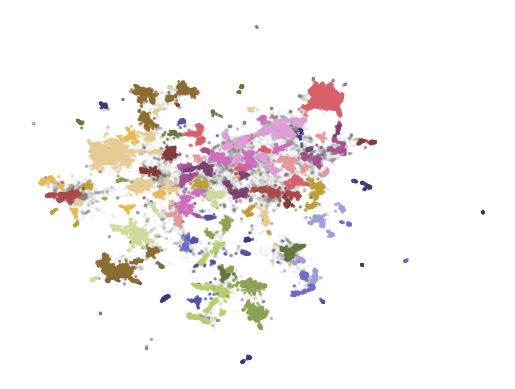

In [9]:
# Plot outliers and non-outliers separately
plt.scatter(outliers.x, outliers.y, alpha=0.05, s=2, c="grey")
plt.scatter(to_plot.x, to_plot.y, c=to_plot.cluster.astype(int), alpha=0.6, s=2, cmap="tab20b")
plt.axis("off")

## Topic modeling
Topic representation is "histogram of keywords": 
$$
c.TF.IDF = \lVert tf_{x,c} \rVert \times \log \left( \frac{A}{cf_{x}} +1 \right)
$$ 
with \
$A=$ total number of documents \
$cf_{x}=$ number of documents containing that word \
$\lVert tf_{x,c} \rVert=$ frequency of that word in cluster $c$

In [10]:
from bertopic import BERTopic
topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    verbose=True
).fit(abstracts, embeddings)

2025-12-20 01:12:52,059 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-12-20 01:13:13,751 - BERTopic - Dimensionality - Completed ✓
2025-12-20 01:13:13,752 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-12-20 01:13:14,351 - BERTopic - Cluster - Completed ✓
2025-12-20 01:13:14,356 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-12-20 01:13:16,188 - BERTopic - Representation - Completed ✓


In [11]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,14147,-1_the_of_and_to,"[the, of, and, to, in, we, language, for, that...","[ In the slot-filling paradigm, where a user ..."
1,0,2138,0_question_qa_answer_questions,"[question, qa, answer, questions, answering, a...",[ Automatic question-answering is a classical...
2,1,2106,1_speech_asr_recognition_end,"[speech, asr, recognition, end, acoustic, spea...","[ We introduce Wav2Seq, the first self-superv..."
3,2,1433,2_medical_clinical_biomedical_patient,"[medical, clinical, biomedical, patient, healt...","[ Clinical texts, such as admission notes, di..."
4,3,1193,3_summarization_summaries_summary_abstractive,"[summarization, summaries, summary, abstractiv...",[ Pre-trained neural abstractive summarizatio...
...,...,...,...,...,...
146,145,53,145_emoji_emojis_emoticons_sentiment,"[emoji, emojis, emoticons, sentiment, social, ...",[ The frequent use of Emojis on social media ...
147,146,53,146_prompt_prompts_optimization_prompting,"[prompt, prompts, optimization, prompting, llm...",[ Prompt optimization aims to find the best p...
148,147,52,147_recipes_recipe_cooking_procedural,"[recipes, recipe, cooking, procedural, food, i...",[ Traditional cooking recipes follow a struct...
149,148,52,148_counseling_mental_therapy_health,"[counseling, mental, therapy, health, psychoth...",[ Mental health care poses an increasingly se...


In [12]:
# which keywords represent best of topic 0
topic_model.get_topic(0)

[('question', np.float64(0.022340243693793543)),
 ('qa', np.float64(0.016724948155861723)),
 ('answer', np.float64(0.016477815021136724)),
 ('questions', np.float64(0.016451127619011487)),
 ('answering', np.float64(0.01544266598601389)),
 ('answers', np.float64(0.010218258287657272)),
 ('retrieval', np.float64(0.009466911883778835)),
 ('comprehension', np.float64(0.008130169312064325)),
 ('reading', np.float64(0.00756697766563166)),
 ('the', np.float64(0.0064144995716838155))]

In [13]:
# get topics highly related to "topic modeling"
topic_model.find_topics("topic modeling")

([25, -1, 2, 48, 34],
 [np.float32(0.9546919),
  np.float32(0.9110571),
  np.float32(0.9074932),
  np.float32(0.9071573),
  np.float32(0.90519613)])

In [14]:
topic_model.get_topic(23)

[('adversarial', np.float64(0.06506191162760301)),
 ('attacks', np.float64(0.03295553990609229)),
 ('attack', np.float64(0.03176207584606561)),
 ('robustness', np.float64(0.023100827508172567)),
 ('examples', np.float64(0.018650193740190855)),
 ('perturbations', np.float64(0.014692695923822859)),
 ('defense', np.float64(0.011129139775095172)),
 ('perturbation', np.float64(0.009978399268521607)),
 ('against', np.float64(0.009284734453586152)),
 ('nlp', np.float64(0.00918081557461124))]

In [15]:
# topic_model.topics_ => list of topic ids of <abstract>s 
title_loc = titles.index("BERTopic: Neural topic modeling with a class-based TF-IDF procedure")
topic_model.topics_[title_loc]

25

In [16]:
# # Visualize topics (clusters)
# fig = topic_model.visualize_documents(
#     titles,
#     reduced_embeddings=reduced_embeddings,
#     width=1200,
#     hide_annotations=True
# )
# fig.update_layout(font=dict(size=16))

In [17]:
# Visualize each topic, with the frequency of its main keywords
topic_model.visualize_barchart()

In [18]:
# Visualize relationships between topics
topic_model.visualize_heatmap(n_clusters=30)

In [19]:
# visualize hierarchical structure of topics
topic_model.visualize_hierarchy()

## Reranker: representation models
To improve order of words in a topic

In [20]:
from copy import deepcopy
original_topics = deepcopy(topic_model.topic_representations_) # {0: [('question',0.022),('qa',0.016),], 1: [...], }
print(original_topics)

{-1: [('the', np.float64(0.006130297883560149)), ('of', np.float64(0.006122654599346995)), ('and', np.float64(0.006065881415582544)), ('to', np.float64(0.00589356963499681)), ('in', np.float64(0.005757777380888513)), ('we', np.float64(0.00557293269743707)), ('language', np.float64(0.005368987949294869)), ('for', np.float64(0.005335768234203974)), ('that', np.float64(0.00530538352340116)), ('on', np.float64(0.005189411907208481))], 0: [('question', np.float64(0.022340243693793543)), ('qa', np.float64(0.016724948155861723)), ('answer', np.float64(0.016477815021136724)), ('questions', np.float64(0.016451127619011487)), ('answering', np.float64(0.01544266598601389)), ('answers', np.float64(0.010218258287657272)), ('retrieval', np.float64(0.009466911883778835)), ('comprehension', np.float64(0.008130169312064325)), ('reading', np.float64(0.00756697766563166)), ('the', np.float64(0.0064144995716838155))], 1: [('speech', np.float64(0.029261026325046728)), ('asr', np.float64(0.01958942064650303

In [21]:
# Show difference between topics words before- and after-representation-model
def topic_differences(model, original_topics, nr_topics=5):
    df = pd.DataFrame(columns=["Topic", "Original", "Updated"])
    # 1st col: 0,1,2..; 2nd col:"a"|"b"|"c"..., 3rd col: "a"|"d"|"z"...
    for topic in range(nr_topics):
        old_words_and_probs = original_topics[topic] # [('question',0.22),('qa',0.16),...]
        new_words_and_probs = model.get_topic(topic)
        # extract 5 words per topic
        # list(zip()) => list of ['question','qa',...] and [0.22,0.16,...] 
        og_words = " | ".join( list(zip(*old_words_and_probs))[0][:5] )
        new_words = " | ".join( list(zip(*new_words_and_probs))[0][:5] )
        df.loc[len(df)] = [topic, og_words, new_words]
    return df 

### 1st representation model type: KeyBERTInspired
1st step: use c-TF-IDF to extract 'histogram' of topic, compare with 'histograms' of all documents in topic, then choose the top-k ones \
2nd step: compare embedding of top-k documents with keyword embedding => rerank keywords (new histogram)

In [22]:
from bertopic.representation import KeyBERTInspired

topic_model.update_topics(abstracts, representation_model=KeyBERTInspired())
topic_differences(topic_model, original_topics)

,Topic,Original,Updated
0,0,question | qa | answer | questions | answering,answering | questions | comprehension | questi...
1,1,speech | asr | recognition | end | acoustic,speech | transcription | phonetic | language |...
2,2,medical | clinical | biomedical | patient | he...,nlp | clinical | annotated | dataset | datasets
3,3,summarization | summaries | summary | abstract...,summarization | summarizing | summarisation | ...
4,4,translation | nmt | machine | neural | bleu,translating | translation | translations | tra...


### 2nd representation model type: MaximalMarginalRelevance
Find keywords that are diverse enough from each other

In [23]:
from bertopic.representation import MaximalMarginalRelevance
representation_model = MaximalMarginalRelevance(diversity=0.2)
topic_model.update_topics(abstracts, representation_model=representation_model)
# show topic difference before <-> after
topic_differences(topic_model, original_topics)

,Topic,Original,Updated
0,0,question | qa | answer | questions | answering,questions | retrieval | comprehension | knowle...
1,1,speech | asr | recognition | end | acoustic,speech | asr | audio | model | training
2,2,medical | clinical | biomedical | patient | he...,medical | clinical | biomedical | patient | pa...
3,3,summarization | summaries | summary | abstract...,summarization | summaries | abstractive | extr...
4,4,translation | nmt | machine | neural | bleu,translation | nmt | neural | parallel | multil...


## Generate label for a topic based on keywords
Step 1: choose 4 documents that are most relevant to that topic (by extract histogram of topic and histograms of all documents) \
Step 2: take keywords of topic \
Step 3: insert to prompt to get label

In [24]:
# With flan-t5 model
from transformers import pipeline 
from bertopic.representation import TextGeneration 

prompt = """ I have a topic that contains the following documents:
[DOCUMENTS]

The topic is described by the following keywords: '[KEYWORDS]'.

Based on the documents and keywords, what is this topic about?
"""
generator = pipeline("text2text-generation", model="google/flan-t5-small")
representation_model = TextGeneration(
    generator, prompt=prompt, doc_length=50, tokenizer="whitespace"
)
topic_model.update_topics(
    abstracts, representation_model=representation_model
)
topic_differences(topic_model, original_topics)

Device set to use cuda:0
100%|█████████████████████████████████████████| 151/151 [00:13<00:00, 11.24it/s]


,Topic,Original,Updated
0,0,question | qa | answer | questions | answering,A deep learning based model for automatic ques...
1,1,speech | asr | recognition | end | acoustic,Speech recognition | | | |
2,2,medical | clinical | biomedical | patient | he...,Science/Tech | | | |
3,3,summarization | summaries | summary | abstract...,"Span-Fact, a suite of two - Sentence summariza..."
4,4,translation | nmt | machine | neural | bleu,Science/Tech | | | |


In [25]:
# Similar, but with GPT3.5
import openai, os
from bertopic.representation import OpenAI
from dotenv import load_dotenv

load_dotenv()
OPENAI_KEY = os.getenv("OPENAI_KEY")

prompt = """
I have a topic that contains the following documents:
[DOCUMENTS]

The topic is described by the following keywords: [KEYWORDS]

Based on the information above, extract a short topic label in the following format:
topic: <short topic label>
"""

# Update topic representations using GPT3.5
client = openai.OpenAI(api_key=OPENAI_KEY)
representation_model = OpenAI(
    client, model="gpt-3.5-turbo", exponential_backoff=True, chat=True, prompt=prompt
)
topic_model.update_topics(abstracts, representation_model=representation_model)
topic_differences(topic_model, original_topics)

100%|█████████████████████████████████████████| 151/151 [01:44<00:00,  1.44it/s]


,Topic,Original,Updated
0,0,question | qa | answer | questions | answering,Question Answering and Reading Comprehension M...
1,1,speech | asr | recognition | end | acoustic,Advancements in Speech Recognition Technology
2,2,medical | clinical | biomedical | patient | he...,Improving Medical Entity Retrieval and Clinica...
3,3,summarization | summaries | summary | abstract...,Evaluating and Enhancing Text Summarization Ap...
4,4,translation | nmt | machine | neural | bleu,Neural Machine Translation (NMT) Training Stra...


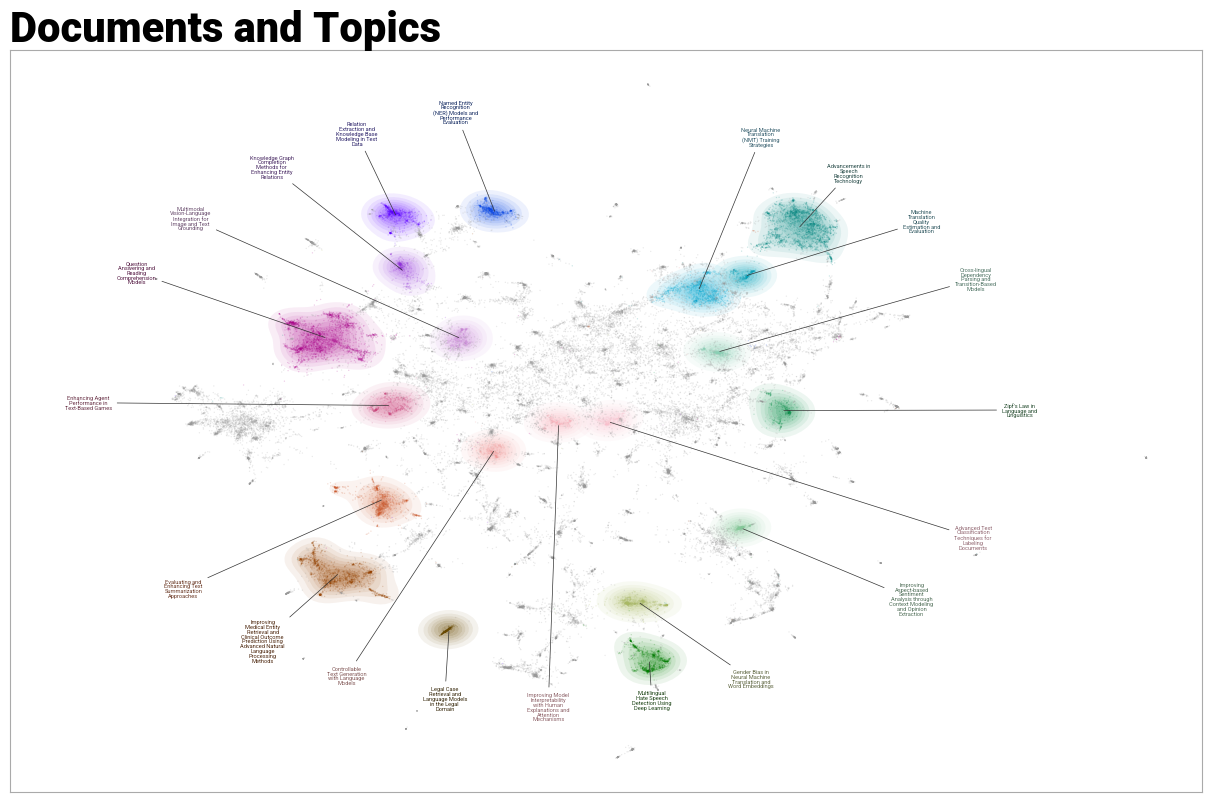

In [26]:
# Visualize the topics & labels
fig = topic_model.visualize_document_datamap(
    titles,
    topics=list(range(20)),
    reduced_embeddings=reduced_embeddings,
    width=1200,
)